Ziel des Projekts: Ähnliche 

Persönliches Ziel: Skincare Recomondation basierend auf Inhaltsstoff und Skintyp. Ich möchte ein ähnliches Produkt (evt. nicht gleiches produkt?) mit ähnlichen Inhaltsstoffen finden und optional meinen Skintyp filtern (ich mochte das Produkt) 

Dataset: https://www.kaggle.com/datasets/eward96/skincare-products-and-their-ingredients

Inspiration: https://www.kaggle.com/code/eward96/skincare-recommendation-engine / https://github.com/rosagradilla19/skincare-products-recommendation-system/blob/main/Comparing-skincare-ingredients.ipynb


Vergleichen: https://skinsort.com/brands/korean-skincare-brands 

Schritte zum Starten eines Projekts:

    Projektziel festlegen: Wähle ein klares und erreichbares Ziel für dein Projekt.
    Daten sammeln: Besorge dir die notwendigen Daten für dein Projekt.
    Daten bereinigen: Bereinige die Daten, um sie für die Analyse vorzubereiten.
    Modell entwickeln: Entwickle und trainiere dein ML-Modell.
    Modell testen und validieren: Teste dein Modell und validiere die Ergebnisse.
    Ergebnisse interpretieren und visualisieren: Analysiere die Ergebnisse und stelle sie verständlich dar.

In [74]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

#Load the data 
df = pd.read_csv("skincare_products.csv")

#Check the first five rows
display(df.head())

display(df.info())

#Inspect the types of products
display(df['product_type'].value_counts())




,product_name,product_url,product_type,ingredients,price
0,The Ordinary Natural Moisturising Factors + HA...,https://www.lookfantastic.com/the-ordinary-nat...,Moisturiser,"Aqua (Water), Caprylic/Capric Triglyceride, Ce...",£5.20
1,CeraVe Facial Moisturising Lotion SPF 25 52ml,https://www.lookfantastic.com/cerave-facial-mo...,Moisturiser,"Aqua/Water, Homosalate, Glycerin, Octocrylene,...",£13.00
2,The Ordinary Hyaluronic Acid 2% + B5 Hydration...,https://www.lookfantastic.com/the-ordinary-hya...,Moisturiser,"Aqua (Water), Sodium Hyaluronate, Sodium Hyalu...",£6.20
3,AMELIORATE Transforming Body Lotion 200ml,https://www.lookfantastic.com/ameliorate-trans...,Moisturiser,"Aqua/Water/Eau, Ammonium Lactate, C12-15 Alkyl...",£22.50
4,CeraVe Moisturising Cream 454g,https://www.lookfantastic.com/cerave-moisturis...,Moisturiser,"Purified Water, Glycerin, Ceteareth-20 and Cet...",£16.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138 entries, 0 to 1137
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_name  1138 non-null   object
 1   product_url   1138 non-null   object
 2   product_type  1138 non-null   object
 3   ingredients   1138 non-null   object
 4   price         1138 non-null   object
dtypes: object(5)
memory usage: 44.6+ KB


None

product_type
Mask           124
Body Wash      123
Moisturiser    115
Cleanser       115
Serum          113
Eye Care       100
Mist            80
Oil             76
Toner           73
Balm            61
Exfoliator      57
Bath Salts      36
Bath Oil        33
Peel            32
Name: count, dtype: int64

In [75]:
#Check for missing Data 

missing_values = df.isnull().sum()

missing_values = missing_values[missing_values > 0]

print(missing_values)

Series([], dtype: int64)


In [76]:
duplicate_rows = df[df.duplicated()]
print("Number of duplicate rows: ", duplicate_rows.shape[0])
df = df.drop_duplicates()

Number of duplicate rows:  0


In [77]:
df.describe()

,product_name,product_url,product_type,ingredients,price
count,1138,1138,1138,1138,1138
unique,1138,1126,14,1090,290
top,The Ordinary Natural Moisturising Factors + HA...,https://www.lookfantastic.com/lancome-advanced...,Mask,"Aqua / Water, Bifida Ferment Lysate, Glycerin,...",£22.00
freq,1,4,124,4,33


In [78]:
#TF-IDF Vektorisierung der Inhaltsstoffe
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['ingredients'])

In [79]:
# In DataFrame umwandeln
X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

In [80]:
# Normalisierung der Daten
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)

In [81]:
# Trainings- und Testdaten aufteilen
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

In [94]:
#Model

# Autoencoder Modell erstellen
def create_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(128, activation='relu')(input_layer)
    encoder = Dense(64, activation='relu')(encoder)
    encoder = Dense(32, activation='relu')(encoder)

    decoder = Dense(64, activation='relu')(encoder)
    decoder = Dense(128, activation='relu')(decoder)
    output_layer = Dense(input_dim, activation='sigmoid')(decoder)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder


# Modell initialisieren
input_dim = X_scaled.shape[1]
autoencoder = create_autoencoder(input_dim)

# Modell trainieren
history = autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=300, validation_split=0.2)

# Modell speichern
autoencoder.save('autoencoder_model.h5')

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 1.3200 - val_loss: 0.9835
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.2891 - val_loss: 0.9320
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.1569 - val_loss: 0.8419
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.0872 - val_loss: 0.7697
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.0776 - val_loss: 0.7475
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.0656 - val_loss: 0.7419
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.0693 - val_loss: 0.7402
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.0492 - val_loss: 0.7396
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.0772 - val_loss: 0.7393
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.0656 - val_loss: 0.7392
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.0591 - val_loss: 0.7392
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.0661 - val_loss: 0.7391


In [85]:
#Schritt 3: Produktempfehlung
# Encoder-Modell extrahieren
encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.layers[-3].output)

# Latente Repräsentationen der Produkte
encoded_products_train = encoder_model.predict(X_train)
encoded_products_test = encoder_model.predict(X_test)

# Funktion zur Berechnung der Kosinus-Ähnlichkeit
def find_similar_products(product_name, df, encoded_products, top_n=5):
    # Index des gesuchten Produkts finden
    product_index = df.index[df['product_name'] == product_name].tolist()
    
    if not product_index:
        print("Produkt nicht gefunden.")
        return None

    product_index = product_index[0]
    
    # Kosinus-Ähnlichkeiten berechnen
    similarities = cosine_similarity([encoded_products[product_index]], encoded_products)[0]
    similar_indices = similarities.argsort()[::-1][1:top_n+1]
    
    return df.iloc[similar_indices]

# Beispiel: Ähnliche Produkte für einen gegebenen Produktnamen finden
product_name = "The Ordinary Natural Moisturising Factors + HA 30ml"
similar_products = find_similar_products(product_name, df, encoded_products_train)

if similar_products is not None:
    print("Original Product:")
    print(df[df['product_name'] == product_name][['product_name', 'product_url', 'product_type', 'price', 'ingredients']])
    print("\nRecommended Products:")
    for i, (index, row) in enumerate(similar_products.iterrows()):
        print(f"\nProduct {i+1}:")
        print(row[['product_name', 'product_url', 'product_type', 'price', 'ingredients']])

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Original Product:
                                        product_name  \
0  The Ordinary Natural Moisturising Factors + HA...   

                                         product_url product_type  price  \
0  https://www.lookfantastic.com/the-ordinary-nat...  Moisturiser  £5.20   

                                         ingredients  
0  Aqua (Water), Caprylic/Capric Triglyceride, Ce...  

Recommended Products:

Product 1:
product_name                       Dr. PAWPAW Original Balm 100ml
product_url     https://www.lookfantastic.com/dr.-pawpaw-origi...
product_type                                                 Balm
price                                                      £18.99
ingredients     Petrolatum, Olea Europaea (Olive) Fruit Oil, C...
Name: 414, dtype: object

Product 2:
product_name       Bondi Sands Liquid Gold Self Tanning Oil 150ml
product_url     https://www.lookfantastic.com/bondi-sands-liq

In [95]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import Model

# Encoder-Modell extrahieren
encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.layers[-3].output)

# Latente Repräsentationen der Produkte
encoded_products_train = encoder_model.predict(X_train)
encoded_products_test = encoder_model.predict(X_test)

# Funktion zur Berechnung der Kosinus-Ähnlichkeit und Inhaltsstoff-Ähnlichkeit
def find_similar_products(product_name, df, encoded_products, top_n=5):
    # Index des gesuchten Produkts finden
    product_index = df.index[df['product_name'] == product_name].tolist()
    
    if not product_index:
        print("Produkt nicht gefunden.")
        return None, None

    product_index = product_index[0]
    
    # Kosinus-Ähnlichkeiten berechnen
    similarities = cosine_similarity([encoded_products[product_index]], encoded_products)[0]
    similar_indices = similarities.argsort()[::-1][1:top_n+1]
    
    similar_products = df.iloc[similar_indices]

    # Inhaltsstoff-Ähnlichkeiten berechnen
    ingredient_lists = df['ingredients'].apply(lambda x: set(x.split(", ")))
    original_ingredients = ingredient_lists.iloc[product_index]
    jaccard_similarities = []

    for index in similar_indices:
        similar_ingredients = ingredient_lists.iloc[index]
        if len(original_ingredients.union(similar_ingredients)) > 0:  # Vermeiden von Division durch Null
            jaccard_sim = len(original_ingredients.intersection(similar_ingredients)) / len(original_ingredients.union(similar_ingredients))
        else:
            jaccard_sim = 0
        jaccard_similarities.append(jaccard_sim)

    return similar_products, jaccard_similarities

# Beispiel: Ähnliche Produkte für einen gegebenen Produktnamen finden
product_name = "Dr. PAWPAW Original Balm 100ml"
similar_products, jaccard_similarities = find_similar_products(product_name, df, encoded_products_train)

if similar_products is not None:
    print("Original Product:")
    print(df[df['product_name'] == product_name][['product_name', 'product_url', 'product_type', 'price', 'ingredients']])
    print("\nRecommended Products:")
    for i, (index, row) in enumerate(similar_products.iterrows()):
        print(f"\nProduct {i+1}:")
        print(row[['product_name', 'product_url', 'product_type', 'price', 'ingredients']])
        print(f"Ingredient Similarity: {jaccard_similarities[i]:.2f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Original Product:
                       product_name  \
414  Dr. PAWPAW Original Balm 100ml   

                                           product_url product_type   price  \
414  https://www.lookfantastic.com/dr.-pawpaw-origi...         Balm  £18.99   

                                           ingredients  
414  Petrolatum, Olea Europaea (Olive) Fruit Oil, C...  

Recommended Products:

Product 1:
product_name    The Ordinary Natural Moisturising Factors + HA...
product_url     https://www.lookfantastic.com/the-ordinary-nat...
product_type                                          Moisturiser
price                                                       £5.20
ingredients     Aqua (Water), Caprylic/Capric Triglyceride, Ce...
Name: 0, dtype: object
Ingredient Similarity: 0.00

Product 2:
product_name                Liz Earle Cleanse & Polish 200ml Tube
product_url     https://www.lookfantastic.com/liz-earle-cle

In [97]:
# Encoder-Modell extrahieren
encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.layers[-3].output)

# Latente Repräsentationen der Produkte
encoded_products = encoder_model.predict(X_scaled)

# Funktion zur Berechnung der Kosinus-Ähnlichkeit und Inhaltsstoff-Ähnlichkeit
def find_similar_products(product_name, df, encoded_products, top_n=5, alpha=0.5):
    # Index des gesuchten Produkts finden
    product_index = df.index[df['product_name'] == product_name].tolist()
    
    if not product_index:
        print("Produkt nicht gefunden.")
        return None, None

    product_index = product_index[0]
    
    # Kosinus-Ähnlichkeiten berechnen
    cosine_similarities = cosine_similarity([encoded_products[product_index]], encoded_products)[0]
    
    # Inhaltsstoff-Ähnlichkeiten berechnen
    ingredient_lists = df['ingredients'].apply(lambda x: set(x.split(", ")))
    original_ingredients = ingredient_lists.iloc[product_index]
    jaccard_similarities = []

    for index in range(len(df)):
        if index == product_index:
            jaccard_similarities.append(0)
            continue
        similar_ingredients = ingredient_lists.iloc[index]
        if len(original_ingredients.union(similar_ingredients)) > 0:  # Vermeiden von Division durch Null
            jaccard_sim = len(original_ingredients.intersection(similar_ingredients)) / len(original_ingredients.union(similar_ingredients))
        else:
            jaccard_sim = 0
        jaccard_similarities.append(jaccard_sim)

    jaccard_similarities = np.array(jaccard_similarities)

    # Kombination der Ähnlichkeiten mit einer Gewichtung
    combined_similarities = alpha * cosine_similarities + (1 - alpha) * jaccard_similarities

    # Top-N ähnliche Produkte finden
    similar_indices = combined_similarities.argsort()[::-1][1:top_n+1]
    
    return df.iloc[similar_indices], combined_similarities[similar_indices]

# Beispiel: Ähnliche Produkte für einen gegebenen Produktnamen finden
product_name = "AMELIORATE Transforming Body Lotion 200ml"
similar_products, similarities = find_similar_products(product_name, df, encoded_products, top_n=5, alpha=0.7)

if similar_products is not None:
    print("Original Product:")
    print(df[df['product_name'] == product_name][['product_name', 'product_url', 'product_type', 'price', 'ingredients']])
    print("\nRecommended Products:")
    for i, (index, row) in enumerate(similar_products.iterrows()):
        print(f"\nProduct {i+1}:")
        print(row[['product_name', 'product_url', 'product_type', 'price', 'ingredients']])
        print(f"Combined Similarity: {similarities[i]:.2f}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Original Product:
                                product_name  \
3  AMELIORATE Transforming Body Lotion 200ml   

                                         product_url product_type   price  \
3  https://www.lookfantastic.com/ameliorate-trans...  Moisturiser  £22.50   

                                         ingredients  
3  Aqua/Water/Eau, Ammonium Lactate, C12-15 Alkyl...  

Recommended Products:

Product 1:
product_name                AMELIORATE Nourishing Body Wash 200ml
product_url     https://www.lookfantastic.com/ameliorate-nouri...
product_type                                            Body Wash
price                                                      £10.50
ingredients     Aqua/Water/Eau, PEG-7 Glyceryl Cocoate, Disodi...
Name: 984, dtype: object
Combined Similarity: 0.79

Product 2:
product_name                 AMELIORATE Nourishing Body Wash 60ml
product_url     https://www.lookfantastic.com/ameliorate-nouri...
product_type         

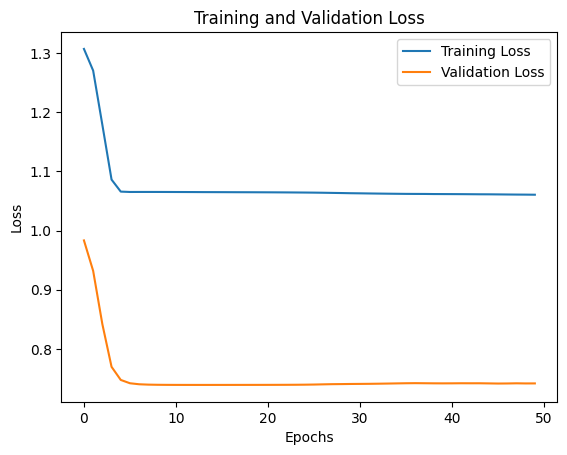

In [98]:
# Trainings- und Validierungsverlust plotten
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

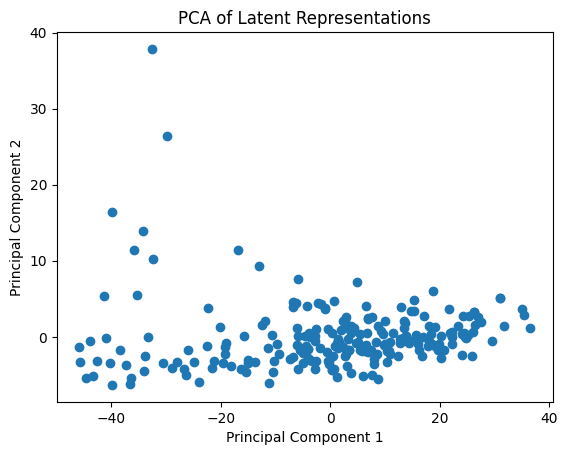

In [99]:
# PCA zur Visualisierung der latenten Repräsentationen
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(encoded_products_test)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1])
plt.title("PCA of Latent Representations")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()